In [156]:
import dash, math, datetime as dt, pandas as pd
from dash.dependencies import Input, Output, State, ClientsideFunction
from dash import dcc, html
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import load_figure_template
import plotly
import plotly.io as pio
import plotly.graph_objects as go 
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm
tqdm.pandas()

%load_ext autoreload
%autoreload 2
import figures, main_etl, extract_data, transform_data

# Seaborn colors  
# ['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', 
# '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Clusterização de portais

In [58]:
import json

with open('data/clusters.d3.json', 'r') as f:
     clusters_json = json.loads(f.read())

In [59]:
clusters_json['children'][:2]

[{'size': 10.0,
  'children': [{'size': 10.0, 'name': '146', 'index': 146}],
  'name': '146',
  'index': 146},
 {'size': 20.0,
  'children': [{'size': 10.0, 'name': '476', 'index': 476},
   {'size': 10.0, 'name': '227', 'index': 227}],
  'name': '227',
  'index': 227}]

In [73]:
clusters.dtypes

cluster_id      object
cluster_size     int64
municipio_id    object
dtype: object

In [88]:
import numpy as np
clusters = []

for cluster in clusters_json['children']:
    for municipio in cluster['children']:
        new_row = [int(cluster['name']), int(cluster['size']/10), int(municipio['name'])]
        clusters.append(new_row) 
        
clusters = pd.DataFrame(clusters, columns=['cluster_id', 'cluster_size', 'municipio_id'])
clusters

,cluster_id,cluster_size,municipio_id
0,146,1,146
1,227,2,476
2,227,2,227
3,92,1,92
4,514,1,514
...,...,...,...
832,0,11,481
833,0,11,359
834,0,11,384
835,0,11,457


In [65]:
municipios = pd.read_csv('data/part-00000', names=['municipio_id', 'html'])
municipios['nome'] = municipios['html'].apply(lambda x: x.split('/')[-1][:-5])

municipios

,municipio_id,html,nome
0,0,/home/pedro/MPMG/html_saver/Conceição do Rio V...,Conceição do Rio Verde
1,1,/home/pedro/MPMG/html_saver/Rio Novo.html,Rio Novo
2,2,/home/pedro/MPMG/html_saver/Cachoeira de Minas...,Cachoeira de Minas
3,3,/home/pedro/MPMG/html_saver/Rio Casca.html,Rio Casca
4,4,/home/pedro/MPMG/html_saver/Periquito.html,Periquito
...,...,...,...
832,832,/home/pedro/MPMG/html_saver/Monte Santo de Min...,Monte Santo de Minas
833,833,/home/pedro/MPMG/html_saver/Prados.html,Prados
834,834,/home/pedro/MPMG/html_saver/Buritizeiro.html,Buritizeiro
835,835,/home/pedro/MPMG/html_saver/Formoso.html,Formoso


In [69]:
cluster_template = pd.read_csv('data/cluster-template.csv')
cluster_template['name_size'] = cluster_template.template + ' (' + cluster_template['n_portais'].astype(str) + ')' 
cluster_template.head()

,rank,cluster_id,template,n_portais,name_size
0,1,5,Síntese Tecnologia e Informática,88,Síntese Tecnologia e Informática (88)
1,2,7,Memory,66,Memory (66)
2,3,1,Siplanweb,61,Siplanweb (61)
3,4,17,Portaltp,61,Portaltp (61)
4,5,6,Portal Fácil,60,Portal Fácil (60)


In [121]:
import json

def build_municipios_clusters_df(clusters_json_path, part_0000_path, cluster_template_path):
    with open(clusters_json_path, 'r') as f:
         clusters_json = json.loads(f.read())

    municipios = []
    for cluster in clusters_json['children']:
        for municipio in cluster['children']:
            new_row = [int(municipio['name']), int(cluster['name']), int(cluster['size']/10)]
            municipios.append(new_row) 
            
    municipios = pd.DataFrame(municipios, columns=['municipio_id', 'cluster_id', 'cluster_size'],
                            dtype=int)

    nomes_municipios = pd.read_csv(part_0000_path, names=['municipio_id', 'municipio'])
    nomes_municipios['municipio'] = nomes_municipios['municipio'].apply(lambda x: x.split('/')[-1][:-5])        
    municipios = municipios.merge(nomes_municipios, on='municipio_id', how='left')

    cluster_template = pd.read_csv(cluster_template_path)
    cluster_template['template_name_size'] = cluster_template.template + \
        ' (' + cluster_template.cluster_n_portais.astype(str) + ')' 
    municipios = municipios.merge(cluster_template, on='cluster_id', how='left')
    
    municipios = municipios.sort_values(['cluster_size', 'template', 'municipio'], 
                                        ascending=[False, True, True])
    municipios = municipios[['municipio_id', 'municipio', 'template', 
                             'cluster_id',	'cluster_size',	'cluster_rank',
                             'cluster_n_portais', 'template_name_size']]
    
    return municipios

#------------------------------------------

municipios = build_municipios_clusters_df('data/clusters.d3.json', 'data/part-00000', 'data/cluster-template.csv')
municipios.to_csv('data/municipios_clusters.csv', index=False)
municipios

,municipio_id,municipio,template,cluster_id,cluster_size,cluster_rank,cluster_n_portais,template_name_size
240,176,Alvorada de Minas,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
247,759,Aricanduva,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
259,726,Augusto de Lima,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
270,666,Berilo,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
201,148,Bocaiúva,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
...,...,...,...,...,...,...,...,...
26,403,Uberlândia,NaN,403,1,NaN,NaN,NaN
137,47,Varjão de Minas,NaN,47,1,NaN,NaN,NaN
614,141,Vazante,NaN,141,1,NaN,NaN,NaN
301,809,Verdelândia,NaN,809,1,NaN,NaN,NaN


In [120]:
municipios[(municipios.cluster_size != municipios.cluster_n_portais) 
           & (municipios.cluster_n_portais.notna())]

,municipio_id,municipio,template,cluster_id,cluster_size,cluster_rank,cluster_n_portais,template_name_size


In [124]:
municipios[municipios.template == 'Betha']['municipio'].values

,municipio_id,municipio,template_name_size,template,cluster_id,cluster_size,cluster_rank,cluster_n_portais
703,98,Alterosa,Betha (26),Betha,3,26,10.0,26.0
720,364,Alto Rio Doce,Betha (26),Betha,3,26,10.0,26.0
698,81,Bandeira do Sul,Betha (26),Betha,3,26,10.0,26.0
704,607,Botelhos,Betha (26),Betha,3,26,10.0,26.0
709,158,Campos Gerais,Betha (26),Betha,3,26,10.0,26.0
699,597,Cataguases,Betha (26),Betha,3,26,10.0,26.0
719,23,Cláudio,Betha (26),Betha,3,26,10.0,26.0
695,233,Congonhas,Betha (26),Betha,3,26,10.0,26.0
696,625,Formiga,Betha (26),Betha,3,26,10.0,26.0
712,347,Ijaci,Betha (26),Betha,3,26,10.0,26.0


## Dashboard com previsão de velocidade

In [ ]:
#TODO descobrir como apagar/deletar a issue
# https://github.com/MPMG-DCC-UFMG/F01/issues/507
# https://help.zenhub.com/support/solutions/articles/43000480335-deleting-github-issues-or-zenhub-epics

In [63]:
epics_df = pd.read_csv("data/epics.csv")

epics_df.groupby(['state','template']).count()['git_issue']

state                    template                      
Coletado                 ADPM                              11
                         Betha                             10
                         Fiorilli                           1
                         GRP                                1
                         Habeas Data                        1
                         Memory                             1
                         PT                                 1
                         Portal fácil (5)                   1
                         Siplanweb                         16
                         Síntese tecnologia informatica    10
                         Template2                          1
Com epic criada          ABO                                1
                         Betha                             13
                         Fiorilli                           1
                         GOVBR                              1
              

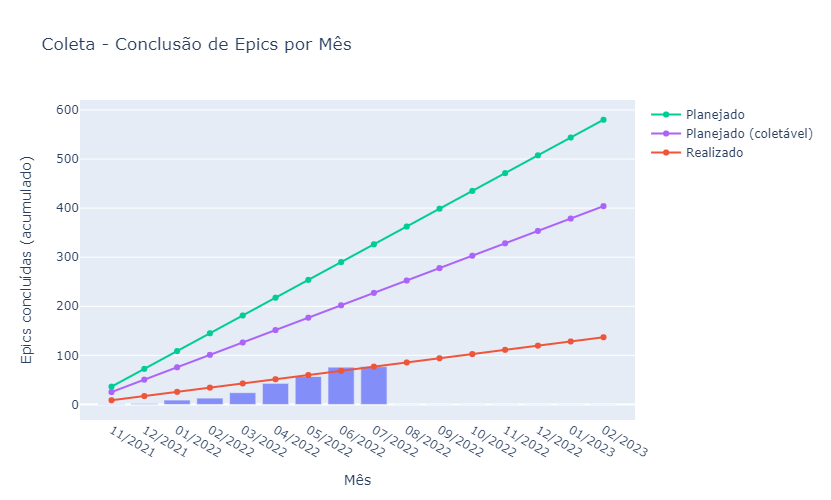

In [116]:
import plotly
import plotly.graph_objects as go 
import plotly.figure_factory as ff
import plotly.express as px

def plot_speed_epics(df, title):     
    
    # Medindo velocidade
    current_speed = df["closed"].mean()          
    df["closed_cumsum"] = df["closed"].cumsum()
    
    df = df.merge( pd.DataFrame(["11/2021", "12/2021"] + [f'{x:02d}/2022' for x in range(1,13)] + 
                                ["01/2023", "02/2023"], columns=["month"]), how="right").fillna(0)          
        
    n_templates = 15 + 5            # 15 + 5 municipios
    total_epics_by_template = 29    # Siplanweb    
    
    total_epics = total_epics_by_template * n_templates    
    total_months = df.shape[0]
    ideal_speed = total_epics / total_months
    
    ### descontando os não-coletáveis
    media_nao_coletavel = (12 + 12 + 12 + 8) / 4   # Siplanweb + Betha + MunicipalNet + ADPM    
    total_coletaveis = total_epics - (media_nao_coletavel * (n_templates-4))   # apenas templates restantes
    ideal_speed_discounted = total_coletaveis / total_months
    
    # Plot
    fig =  px.bar(df, x="month", y="closed_cumsum", title=title, opacity=0.75, height=500,
                 labels={"closed_cumsum":"Epics concluídas (acumulado)", "month":"Mês"})
    extract_data.get_info_issues_by_id
    fig.update_layout(yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 100))
    fig.add_traces([
        go.Scatter(x=df.month, y=[i * ideal_speed for i in range(1, total_months+1)], name="Planejado",
                  line=go.scatter.Line(color="#00CC96")),
        go.Scatter(x=df.month, y=[i * ideal_speed_discounted for i in range(1, total_months+1)], name="Planejado (coletável)",
                  line=go.scatter.Line(color="#AB63FA")),
        go.Scatter(x=df.month, y=[i * current_speed for i in range(1, total_months+1)], name="Realizado",
                  line=go.scatter.Line(color="#EF553B"))#, text=df),
    ])
    
    return fig

#-------------------------------------------------------------------------------------

count_epics_month_df = pd.read_csv("data/count_epics_month.csv")
plot_speed_epics(count_epics_month_df, title='Coleta - Conclusão de Epics por Mês')


In [121]:
info_issues['closed_by'].append(issue.closed_by.name if issue.closed_by else None)

'Coletas Fechadas / Total: 3 / 4'

## Update Dados Coleta

In [127]:
%%time 
import main_etl

with open('tokens.txt') as f:
     git_token, zh_token = [line.rstrip('\n') for line in f.readlines()]    
        
# main_etl.update_data_coletas(git_token, zh_token)

CPU times: user 124 µs, sys: 12 µs, total: 136 µs
Wall time: 93.9 µs


In [401]:
        
g = Github(git_token)
# repo_C01 = g.get_repo("MPMG-DCC-UFMG/C01")
repo_F01 = g.get_repo("MPMG-DCC-UFMG/F01")
i = repo_F01.get_issue(108)
print(i, i.state, i.labels)

Issue(title="Coletor para o template Portal Fácil - Despesas", number=108) closed [Label(name="wontfix"), Label(name="Epic"), Label(name="tag-Despesas")]


In [419]:
df[df.git_issue == 117]

,title,git_issue,created_at,closed_at,state,template,tag,subtag,aux


In [415]:
df = pd.read_csv('data/epics.csv')
df.groupby('state').count()

,title,git_issue,created_at,closed_at,template,tag,subtag,aux
state,,,,,,,,
Coletado,77,77,77,77,70,71,39,77
Com epic criada,35,35,35,0,31,35,9,35
Não coletável,35,35,35,35,35,35,25,35


In [418]:
df[df.tag.isna()]

,title,git_issue,created_at,closed_at,state,template,tag,subtag,aux
0,Coletor para o template ABO,1143,2022-01-05 13:07:41,2022-01-05 13:08:55,Coletado,NaN,NaN,NaN,1
34,Coletor para o template betha cloud,116,2022-01-05 12:50:15,2022-07-11 20:40:22,Coletado,NaN,NaN,NaN,1
35,Coletor para o template ABO,118,2022-01-05 13:10:18,2022-07-11 20:38:56,Coletado,NaN,NaN,NaN,1
57,Coletor para o template Sinplanweb - Contas Pú...,504,2022-04-28 12:28:33,2022-05-06 12:48:14,Coletado,Siplanweb,NaN,Contas Públicas,1
59,Coletor para o template Sinplanweb - Orçamento...,508,2022-05-06 12:56:20,2022-05-06 12:56:27,Coletado,NaN,NaN,NaN,1
63,Coletor para o template ADPM - Despesas - Geral,507,2022-05-05 14:30:25,2022-06-08 16:18:50,Coletado,NaN,NaN,NaN,1


In [416]:
df[df.template.isna()]

,title,git_issue,created_at,closed_at,state,template,tag,subtag,aux
0,Coletor para o template ABO,1143,2022-01-05 13:07:41,2022-01-05 13:08:55,Coletado,NaN,NaN,NaN,1
7,Coletor para o template Portal Cidadão - Despesas,112,2021-12-14 17:16:37,2022-07-11 19:33:37,Coletado,NaN,Despesas,NaN,1
16,Coletor para o template ABO - Despesas - Relat...,1422,2022-07-28 13:09:35,NaN,Com epic criada,NaN,Despesas,Contas Públicas,1
34,Coletor para o template betha cloud,116,2022-01-05 12:50:15,2022-07-11 20:40:22,Coletado,NaN,NaN,NaN,1
35,Coletor para o template ABO,118,2022-01-05 13:10:18,2022-07-11 20:38:56,Coletado,NaN,NaN,NaN,1
59,Coletor para o template Sinplanweb - Orçamento...,508,2022-05-06 12:56:20,2022-05-06 12:56:27,Coletado,NaN,NaN,NaN,1
63,Coletor para o template ADPM - Despesas - Geral,507,2022-05-05 14:30:25,2022-06-08 16:18:50,Coletado,NaN,NaN,NaN,1
94,Coletor para o template Portal Fácil - Despesas,108,2021-12-14 17:02:10,2022-07-13 10:50:52,Coletado,NaN,Despesas,NaN,1
126,Coletor para Uberlândia - Licitações,484,2022-04-20 01:24:10,NaN,Com epic criada,NaN,Licitação,NaN,1
129,Coletor para Juiz de Fora - Despesas,485,2022-04-20 01:27:40,NaN,Com epic criada,NaN,Despesas,NaN,1


In [406]:
df = pd.read_csv('data/epics.csv')
print(df.shape)
df[df.git_issue == 108]

(147, 9)


,title,git_issue,created_at,closed_at,state,template,tag,subtag,aux
94,Coletor para o template Portal Fácil - Despesas,108,2021-12-14 17:02:10,2022-07-13 10:50:52,Coletado,NaN,Despesas,NaN,1


### Testing update

In [383]:
from github import Github

def get_name(issue_id, repo):
    try:
        issue = repo.get_issue(issue_id)
    except:
        return None
    
    closed_by = issue.closed_by
    
    if not closed_by:
        return None    
    if closed_by.name:
        return closed_by.name
    if closed_by.login:
        return closed_by.login
    
    return None

with open('tokens.txt') as f:
     git_token, zh_token = [line.rstrip('\n') for line in f.readlines()]    
        
g = Github(git_token)
repo_C01 = g.get_repo("MPMG-DCC-UFMG/C01")

df = pd.read_csv('data/df.csv')
df = df[df.state == 'closed']
df.shape

(3047, 13)

In [384]:
d = pd.read_csv('data/df.csv.bkp', usecols=['number', 'closed_by'])
df = df.merge(d, on='number', how='left')
df = df[df.closed_by.isna()].reset_index(drop=True)
df.shape

(47, 14)

In [385]:
df.loc[:900, 'closed_by'] = df.loc[:900, 'number'].progress_apply(lambda i : get_name(i, repo_C01))
# df.loc[900:1800, 'closed_by'] = df.loc[900:1800, 'number'].progress_apply(lambda i : get_name(i, repo_C01))
df.closed_by = df.closed_by.str[:3]
print( df[df.closed_by.isna()].shape )

d = pd.read_csv('data/df.csv.bkp')
assert( df.merge(d, on='number', how='inner').shape[0] == 0) 
df = pd.concat([d, df])
df.aux = 1
print(df.shape)
# df.to_csv('data/df.csv.bkp', index=False)

100%|██████████| 47/47 [00:21<00:00,  2.19it/s]

(0, 14)
(3047, 15)


In [388]:
df = pd.read_csv('data/df.csv.bkp')
p = ['Art', 'Gab', 'Isa', 'luc', 'jor', 'Ant', 'raf', 'Mar']
df = df[df.closed_by.isin(p)].sort_values('closed_by')

fig = px.histogram(df, x='closed_by', y='aux', title='Coletas Fechadas (C01)',
             width=800, height=500)

year_months = []
for year in pd.unique(df['year']).tolist():
    for month in pd.unique(df[df.year == year]['month'].sort_values(ascending=False)).tolist():
        year_months.append((year, month))
        
buttons = []
buttons.append(dict(method = "restyle", 
                    args = [{'y': [df['aux']], 'x': [df['closed_by']]}], 
                    label = "Meses"))

for year, month in year_months:
    aux = df.loc[(df['year'] == year) & (df['month'] == month)]
    for x in p:
        if x not in aux.closed_by.unique().tolist():
            aux = pd.concat([aux, pd.DataFrame([{'closed_by':x, 'year':year, 'month':month, 'aux':0.01}])])
    
    buttons.append(dict(method = "restyle",
            args = [{'y': [aux['aux']], 'x': [aux['closed_by']]}], 
            label = str(year)+'-'+str(month)))

# fig.update_layout(autosize=True, updatemenus=[dict(active=0, buttons=buttons)])


In [243]:
df[df.closed_by.str.startswith('jor')].shape

(45, 15)

In [234]:
#epics
repo_F01 = g.get_repo("MPMG-DCC-UFMG/F01")

df = pd.read_csv('data/epics.csv')
df = df[df.closed_at.notna()][1:]  #TODO ABO
print(df.shape)

df['closed_by'] = df['git_issue'].progress_apply(lambda i: get_name(i, repo_F01)).str[:3]
df.to_csv('data/epics.csv.bkp', index=False)

(107, 9)


100%|██████████| 107/107 [00:46<00:00,  2.31it/s]


In [271]:
df = pd.read_csv('data/epics.csv.bkp')
print( df[df.closed_by.isna()].shape )
# p = df.closed_by.unique()

fig = px.bar(df, x='closed_by', y='aux', title='Epics', #color='state', #TODO duplication problem
       width=800, height=400)

df['closed_at'] = df['closed_at'].str[:7]

year_months = pd.unique(df['closed_at'].sort_values(ascending=False)).tolist()
        
buttons = []
buttons.append(dict(method = "restyle", 
                    args = [{'y': [df['aux']], 'x': [df['closed_by']]}], 
                    label = "Meses"))

for year_month in year_months:
    aux = df.loc[(df['closed_at'] == year_month)]
    for x in p:
        if x not in aux.closed_by.unique().tolist():
            aux = pd.concat([aux, pd.DataFrame([{'closed_by':x, 'closed_at':year_month, 'aux':0.01}])])
    
    buttons.append(dict(method = "restyle",
            args = [{'y': [aux['aux']], 'x': [aux['closed_by']]}], 
            label = year_month))

# fig.update_layout(autosize=True, updatemenus=[dict(active=0, buttons=buttons)])


(0, 10)


## Dashboard Desenvolvimento

In [ ]:
exigencias_df = pd.read_csv("data/exigencias_dev.csv", usecols=["tag","subtag"]).drop_duplicates()
exigencias_df

In [ ]:
epics_dev_df = pd.read_csv("data/tmp.csv").drop(columns=['title', 'tag', 'subtag']).drop_duplicates(
    'template', ignore_index=True).dropna(subset=['template'])

epics_dev_df = epics_dev_df.merge(exigencias_df, how='cross')
epics_dev_df["title"] = epics_dev_df["tag"] + ": " + epics_dev_df["subtag"]
epics_dev_df = epics_dev_df.pivot(index="template", columns="title", values="state")

epics_dev_df[:] = 3

epics_dev_df.to_csv("data/epics_dev.csv")
epics_dev_df

In [ ]:
epics_dev_df = pd.read_csv("data/top_templates.csv")

epics_dev_df = epics_dev_df[epics_dev_df['rank'] <= 15]
epics_dev_df = epics_dev_df.merge(exigencias_df, how='cross')
epics_dev_df["title"] = epics_dev_df["tag"] + ": " + epics_dev_df["subtag"]
epics_dev_df = epics_dev_df.drop(columns=['tag', 'subtag'])

y_label = "template_rank"
epics_dev_df[y_label] = epics_dev_df["template"] + " (" + epics_dev_df["rank"].astype(str) + "º)"
epics_dev_df = epics_dev_df.drop(columns=["template"])

epics_dev_df = epics_dev_df.pivot(index="template_rank", columns="title", values="rank")
epics_dev_df[:] = 4

epics_dev_df.to_csv("data/epics_dev.csv")
epics_dev_df

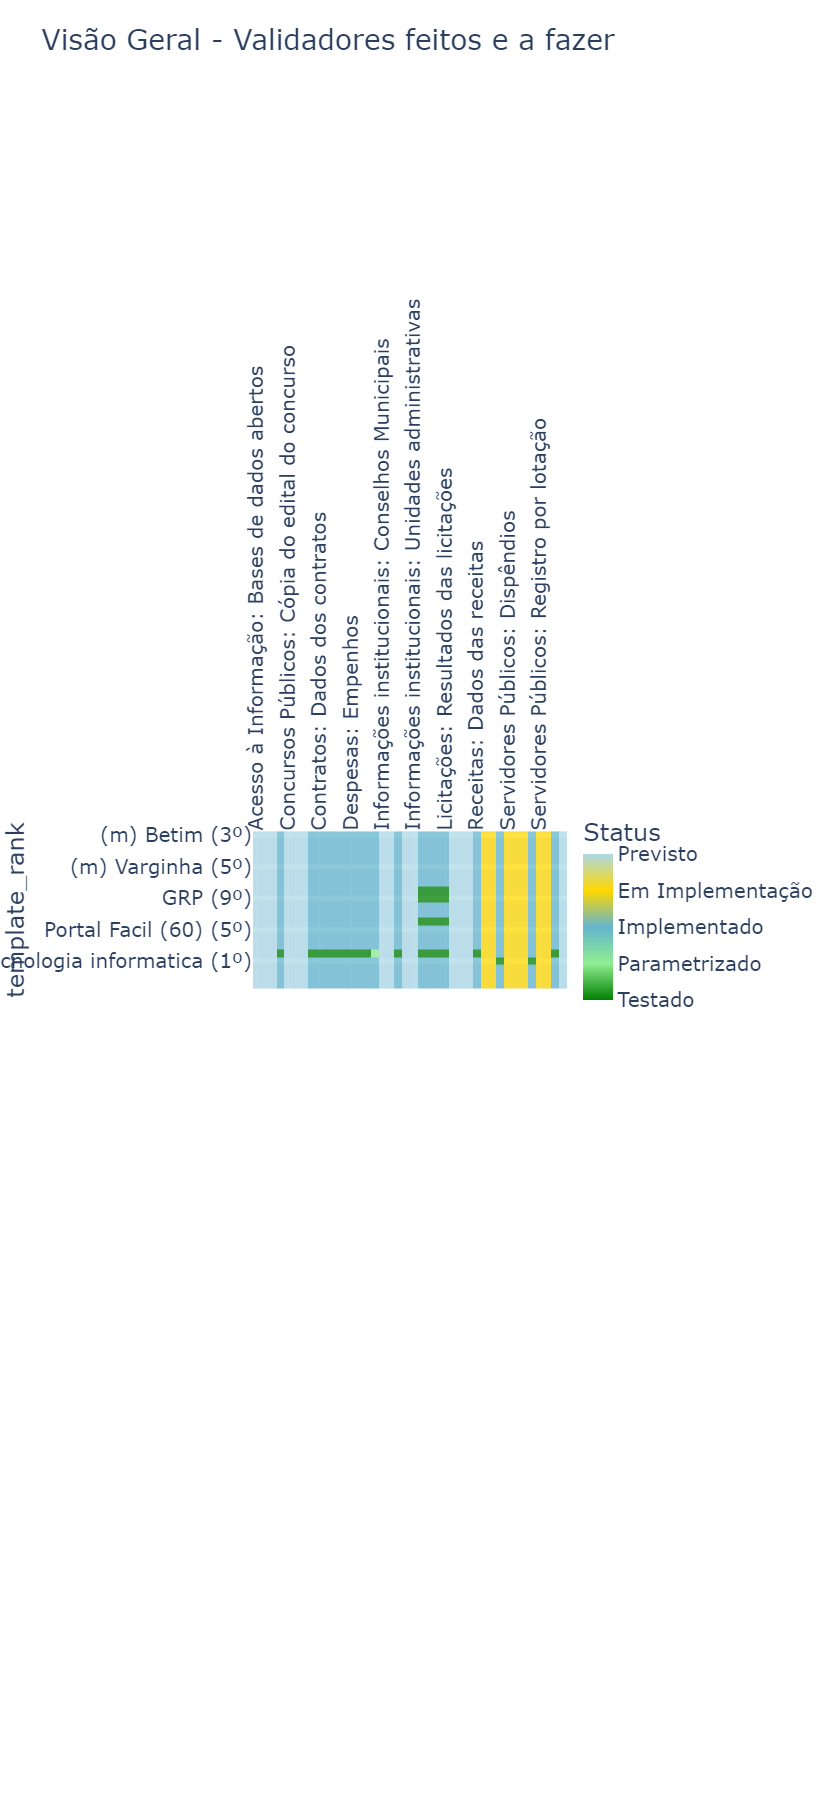

In [389]:
import plotly.express as px
import matplotlib.pyplot as plt

def plot_status_epics_dev(df, title, y_column, x_column, hue, showlegend=True):    

    fig = px.imshow(
        df, height=1800, width=1700, title=title,
        color_continuous_scale=[(0, "green"), (0.25, 'lightgreen'), (0.5, "#64b5cd"), 
                                (0.75, '#FFD700'), (1, 'lightblue')]
    )     
        
    fig.update_traces(opacity=0.75)
    fig.update_xaxes(tickangle=-90, side="top")
    fig.update_yaxes(showgrid=True, gridwidth=5)
    
    fig.update_layout(
        coloraxis_colorbar=dict(
            title="Status", 
            tickvals=[1,2,3,4,5],
            ticktext=["Testado","Parametrizado","Implementado","Em Implementação",'Previsto'],
            lenmode="pixels", 
            len=200), 
        font=dict(size=20)
    )
    
    return fig

#-----------------------------------------------------------------------

figures.plot_status_epics_dev = plot_status_epics_dev

epics_dev_df = pd.read_csv("data/epics_dev.csv", index_col="template_rank")

fig = figures.plot_status_epics_dev(epics_dev_df, title='Visão Geral - Validadores feitos e a fazer',        
        y_column='template', x_column='title', hue="state", showlegend=True)


fig.write_image('./fig/status-dev.png')#, scale=1)
fig

# fechou siplan:link de acesso, dados de contratos, 
# conteudo integral, gerar relatório sintese: dados de serviddores, aberto sintese:licitacoes

## Coleta: Epics por Template

In [327]:
def plot_pre_coleta(df, title='Resultados da Sondagem Automática'):
    df = df.sort_index(axis=0)
    df = df.reindex(sorted(df.columns), axis=1)

    fig = px.imshow(
        df, height=900, width=800, title=title,
        # color_continuous_scale=[(0, "red"), (1, 'lightblue')]   # 2-state
        color_continuous_scale=[(0, "white"), (0.5, "red"), (1, 'lightblue')]  # 3-state
    )     
        
    fig.update_traces(opacity=0.75)
    fig.update_xaxes(tickangle=-90, side="top")
    fig.update_xaxes(showgrid=True, gridwidth=5)
    
    fig.update_layout(
        coloraxis_colorbar=dict(
            title="Subtag", 
            tickvals=[-1, 0, 1],
            ticktext=['Indeterminado', 'Não localizada', 'Localizada'],
            lenmode="pixels", 
            len=140), 
        font=dict(size=14)
    )
    
    return fig

(15, 20)


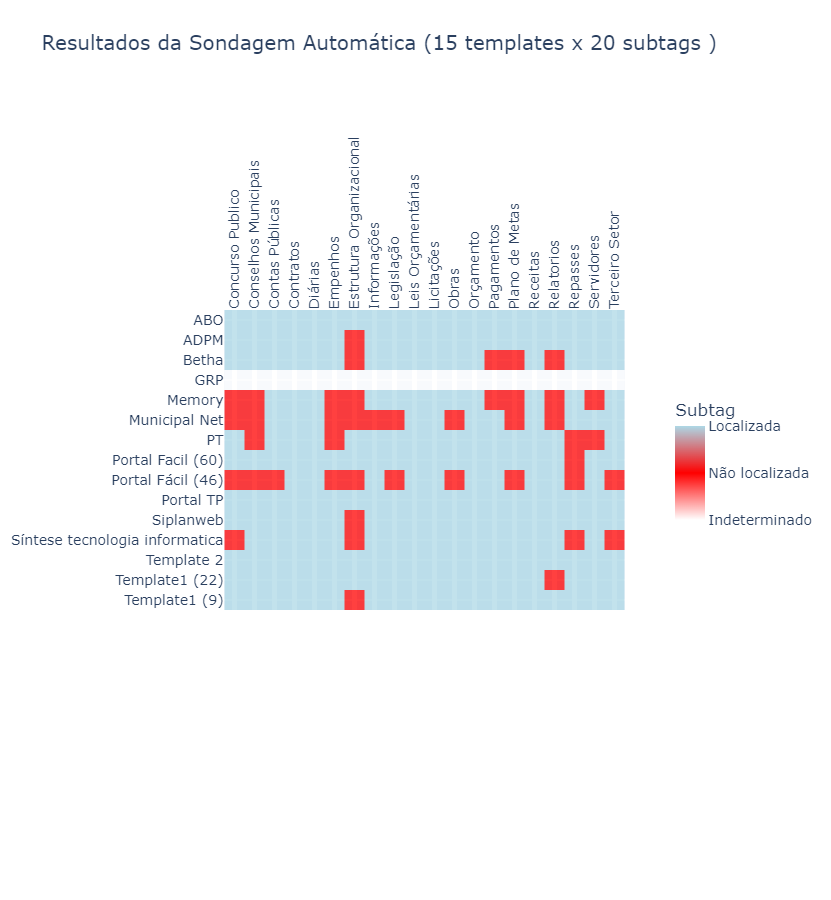

In [362]:
#NOTE muitos erros no nome do portal 
s = pd.read_csv('data/resultados_templates.csv', index_col=0).astype(int)

# Correcao temporariamente necessaria 
# s = s.rename(index={
#     'Porta Fácil (60)': 'Portal Facil (60)',
#     'Porta Fácil (46)': 'Portal Fácil (46)',
#     'Template 1 (22)': 'Template1 (22)',
#     'Template 1 (9)': 'Template1 (9)',
#     'Portla TP': 'Portal TP',
#     'Sintese e Tecnologia':'Síntese tecnologia informatica',
# })
# s.loc['GRP'] = -1
# s.to_csv('data/resultados_templates.csv')

print(s.shape)

plot_pre_coleta(s, title='Resultados da Sondagem Automática (' + 
                str(s.shape[0]) + ' templates x ' + str(s.shape[1]) + ' subtags )')

# GRP, Memory, Template 1 (9), Portal facil (60) e Portal Facil (46)

### Gráfico de Visão Geral

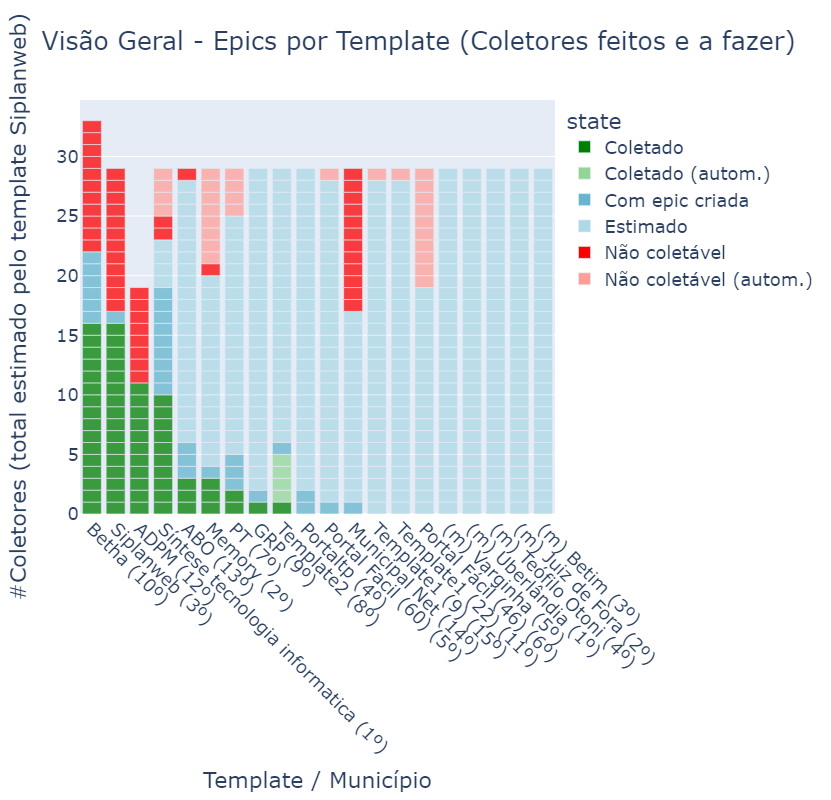

In [382]:
# TODO melhorar automacao
def plot_status_epics(df, top_templates_df, sondagem_df, title='Visão Geral - Epics por Template (Coletores feitos e a fazer)'):

    templates_ja_analisados = ['ADPM', 'Betha', 'Municipal Net', 'Siplanweb']
    s = sondagem_df[sondagem_df == 0].count(axis=1)
    s = s[s != 0]
    s = s.drop(templates_ja_analisados)
    s = s.sort_index()
    nao_loc_autom = dict(s)
    
    # Fonte: Planilha Controle de Dados (#TODO transformar em Epics com "não-localizado")
    nao_loc_manual = {'Municipal Net': 12}
    coletado_autom = {'Template2': 4}
    
    for template, count in nao_loc_autom.items():
        for i in range(count):
            df = df.append({'template':template, 'state':'Não coletável (autom.)', 'aux':1}, ignore_index=True)
            
    for template, count in nao_loc_manual.items():
        for i in range(count):
            df = df.append({'template':template, 'state':'Não coletável', 'aux':1}, ignore_index=True)
            
    for template, count in coletado_autom.items():
        for i in range(count):
            df = df.append({'template':template, 'state':'Coletado (autom.)', 'aux':1}, ignore_index=True)
    
    # Pre-process dataframes       
    count_col = 'aux'
    state_col = 'state'  
    top_templates_df = top_templates_df[top_templates_df['rank'] <= 15]
    df = top_templates_df.merge(df, how='left').fillna({state_col:'Estimado', count_col:1})
    templates = df['template'].dropna().unique()    
    
    total_ref = 29  # Siplanweb  
    total = dict.fromkeys(templates, total_ref)
    total['Betha'] = 33
    total['ADPM'] = 19
    
    # Fill missing (estimated) epics in df
    for template in templates:        
        created =  df.groupby('template').count()[state_col][template]
        missing = total[template] - created                
        rank = df[df.template == template]['rank'].values[0]  #TODO drop rank?
        
        for i in range(missing):            
            df = df.append({'template':template, state_col:'Estimado', 'rank':rank, count_col:1}, ignore_index=True)    

    # Add a better name for x values
    x = "template_rank"
    df[x] = df["template"] + " (" + df["rank"].astype(str) + "º)"
    df = df.sort_values(by=[state_col, x], ascending=[True, False])
    xorder = df.groupby(['state','template_rank']).count()['rank'][
        'Coletado'].sort_values(ascending=False).index.tolist()

    # Plot
    fig = px.bar(
        df, y=count_col, x=x, color=state_col, height=800, width=1100, title=title,
        color_discrete_map = {"Coletado":"green", 
                              "Coletado (autom.)":"#92d696", 
                              "Com epic criada":"#64b5cd", 
                              'Estimado':'lightblue', 
                              'Não coletável':'red', 
                              'Não coletável (autom.)':'#ff9e99'}, 
        labels = {count_col:"#Coletores (total estimado pelo template Siplanweb)", 
                  x:"Template / Município"}, opacity=0.75 )    
    
    fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':xorder})
    fig.update_xaxes(tickangle=45)
    fig.update_layout(font=dict(size=18))    
    
    return fig

#-------------------------------------------------------------

epics_df = pd.read_csv("data/epics.csv")
top_templates_df = pd.read_csv("data/top_templates.csv")
sondagem_df = pd.read_csv('data/resultados_templates.csv', index_col=0).astype(int)

fig = plot_status_epics(epics_df, top_templates_df, sondagem_df)    
fig.write_image('./fig/status-coleta.png', scale=1)
fig

# https://www.color-hex.com/color/4abc50 tints

In [381]:
e = pd.read_csv("data/epics.csv")
e = e[(e.template == 'Síntese tecnologia informatica')]

e.groupby('state').count()

,title,git_issue,created_at,closed_at,template,tag,subtag,aux
state,,,,,,,,
Coletado,10,10,10,10,10,10,7,10
Com epic criada,9,9,9,0,9,9,0,9
Não coletável,2,2,2,2,2,2,2,2


In [74]:
# TODO completar issues sem labels (branco)

## Outros gráficos

In [1]:
import os
import spacy
from github import Github
from zenhub import Zenhub
import pandas as pd
import numpy as np

import plotly.graph_objects as go 

nlp = spacy.load('pt_core_news_sm')

repo_id='357557193'

In [2]:
import pickle
import dash
from dash.dependencies import Input, Output, State, ClientsideFunction
from dash import dcc
from dash import html
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import load_figure_template

import plotly
import plotly.figure_factory as ff
import plotly.io as pio

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None 

In [148]:
import extract_data
import transform_data
import figures

In [251]:
%load_ext autoreload
%autoreload 2

import main_etl
import app
import figures
import extract_data
import transform_data
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from github import Github
from zenhub import Zenhub

In [6]:
repo_id_f01='357557193'
git_token=<TOKEN>
zh_token=<TOKEN>

In [7]:
zh = Zenhub(zh_token)
g = Github(git_token)
    
repo_C01 = g.get_repo("MPMG-DCC-UFMG/C01")
repo_F01 = g.get_repo("MPMG-DCC-UFMG/F01")

In [355]:
main_etl.job()

In [205]:
def get_info_epics_by_id(epics_id, filter_data=False):
    
    data = {'title': [], 'id':[] , 'tag':[], 'template': [], 'status': []}

    for epic_id in epics_id:
    
        issue = repo_F01.get_issue(epic_id)
        labels = issue.labels
        labels = [i.name for i in labels]
    
        if 'generalization test' in labels or filter_data:

            data['title'].append(issue.title)
            data['id'].append(epic_id)
            data['tag'].append(extract_data.get_specific_labels(labels, pattern='tag'))
            data['template'].append(extract_data.get_specific_labels(labels, pattern='template'))
            data['status'].append(issue.state)
        
    df = pd.DataFrame(data)
    
    return df

In [184]:
def get_info_issues_by_id(ids):
    
    data = {'title': [], 'id':[], 'status': [], 'created_at':[], 'closed_at':[]}
    
    for issue_id in ids:
    
        issue = repo_F01.get_issue(issue_id)
    
        data['title'].append(issue.title)
        data['id'].append(issue_id)
        data['status'].append(issue.state)
        data['created_at'].append(issue.created_at)
        data['closed_at'].append(issue.closed_at)
        
    df = pd.DataFrame(data)
    
    return df

In [253]:
def main_job2():
    epics_id = extract_data.get_epics_ids(zh, repo_id_f01)
    epics_df = extract_data.get_info_filtered_issues(epics_id, repo_F01)

    epics_id_dev = list(epics_df['id'])
    issues_data = extract_data.get_data_epics(zh, epics_id_dev, repo_id_f01)
    epics_info = extract_data.get_epics_info(repo_F01, issues_data)
    epics_info_df = pd.DataFrame(epics_info).T.reset_index()

    exploded_df = epics_info_df.explode('issues').reset_index(drop=True)

    exploded_df = exploded_df.loc[~exploded_df['issues'].isna()]
    issues_id = exploded_df['issues'].tolist()

    info_issues_dev = extract_data.get_info_issues_by_id(issues_id, repo_F01)

    info_issues_dev.to_csv("data/info_issues_dev.csv", index=False)
    info_issues_dev = pd.read_csv("data/info_issues_dev.csv")

    info_issues_dev['closed_at'] = info_issues_dev['closed_at'].fillna(0)
    info_issues_dev = transform_data.format_date(info_issues_dev, time_column='closed_at', status='closed')
    info_issues_dev = transform_data.format_date(info_issues_dev, time_column='created_at', status='created')

    closed_df = info_issues_dev.pivot_table(values='title', index=['id'], columns='format_date_closed', aggfunc='count').fillna(0).reset_index()
    closed_df.drop('1/1970', axis = 1,inplace=True)

    open_df = info_issues_dev.pivot_table(values='title', index=['id'], columns='format_date_created', aggfunc='count').fillna(0).reset_index()

    columns_name = transform_data.sort_columns(open_df)
    open_df = open_df[columns_name]

    columns_name = transform_data.sort_columns(closed_df)
    closed_df = closed_df[columns_name]

    count_month_dev = transform_data.count_by_month(open_df, closed_df)

    df = info_issues_dev.merge(exploded_df, left_on='id', right_on='issues')
    df = df.groupby(['template','tag', 'status'])['status'].count().unstack().reset_index().fillna(0)
    df = df.sort_values('closed', ascending=False)

    count_month_dev.to_csv("data/count_month_dev.csv", index=False)
    open_df.to_csv("data/open_df_dev.csv", index=False)
    closed_df.to_csv("data/closed_df_dev.csv", index=False)
    df.to_csv("data/coletas_tag_dev.csv", index=False)

In [254]:
main_job2()

In [211]:
issues_id = exploded_df['issues'].tolist()

In [185]:
info_issues_dev = get_info_issues_by_id(issues_id)

In [256]:
info_issues_dev['week'] =  pd.to_datetime(info_issues_dev['closed_at']).dt.strftime('%W')
week_status = transform_data.count_by_week(info_issues_dev, column_to_group='week', time_column='closed_at')

In [259]:
week_status.to_csv("data/week_status_dev.csv", index=False)

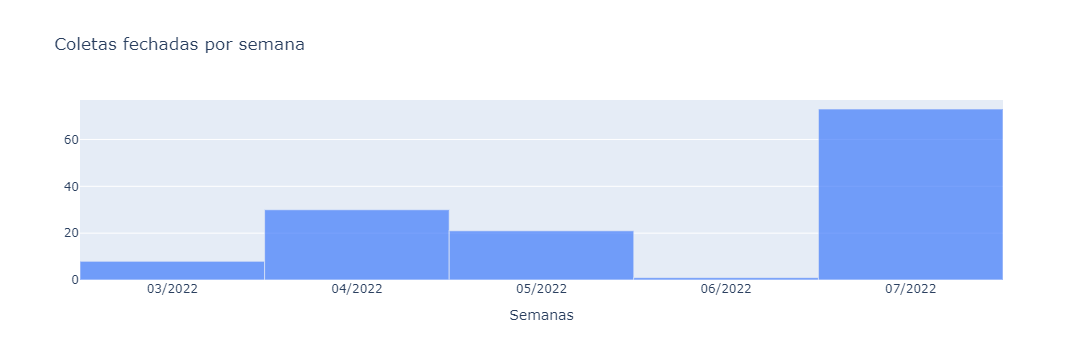

In [258]:
figures.plot_status_week(
        week_status, y_column='closed_at', x_column='week',
        title='Coletas fechadas por semana', xaxis_title_text='Semanas')

In [187]:
info_issues_dev.to_csv("data/info_issues_dev.csv", index=False)
info_issues_dev = pd.read_csv("data/info_issues_dev.csv")

In [188]:
info_issues_dev['closed_at'] = info_issues_dev['closed_at'].fillna(0)
info_issues_dev = transform_data.format_date(info_issues_dev, time_column='closed_at', status='closed')
info_issues_dev = transform_data.format_date(info_issues_dev, time_column='created_at', status='created')

In [189]:
closed_df = info_issues_dev.pivot_table(values='title', index=['id'], columns='format_date_closed', aggfunc='count').fillna(0).reset_index()
closed_df.drop('1/1970', axis = 1,inplace=True)

open_df = info_issues_dev.pivot_table(values='title', index=['id'], columns='format_date_created', aggfunc='count').fillna(0).reset_index()

In [190]:
columns_name = transform_data.sort_columns(open_df)
open_df = open_df[columns_name]

columns_name = transform_data.sort_columns(closed_df)
closed_df = closed_df[columns_name]

In [231]:
count_month_dev = transform_data.count_by_month(open_df, closed_df)

In [192]:
x = open_df.columns[1:].tolist()
z = open_df.columns[1:]
y = 'municipio'

closed_colum='closed'
open_colum='open'

fig1 = figures.plot_status_mes(
        count_month, x_column=x, name1='Issues de generalização abertas', name2="Issues de generalização fechadas",
        y1_column=open_colum, y2_column=closed_colum, title='Generalizações por mês')

In [232]:
count_month_dev.to_csv("data/count_month_dev.csv", index=False)

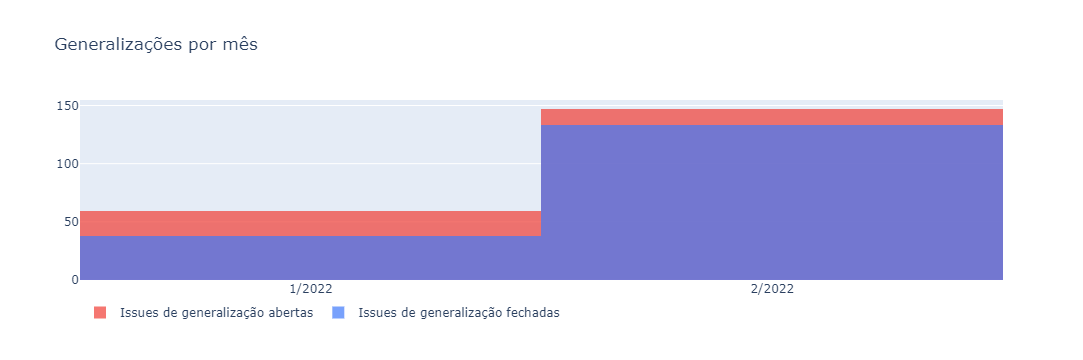

In [193]:
fig1.show()

In [239]:
open_df.to_csv("data/open_df_dev.csv", index=False)
closed_df.to_csv("data/closed_df_dev.csv", index=False)

In [240]:
closed_df.to_csv("data/closed_df_dev.csv", index=False)

In [223]:
df = info_issues_dev.merge(exploded_df, left_on='id', right_on='issues')
df = df.groupby(['template','tag', 'status'])['status'].count().unstack().reset_index().fillna(0)
df = df.sort_values('closed', ascending=False)

In [233]:
df.to_csv("data/coletas_tag_dev.csv", index=False)

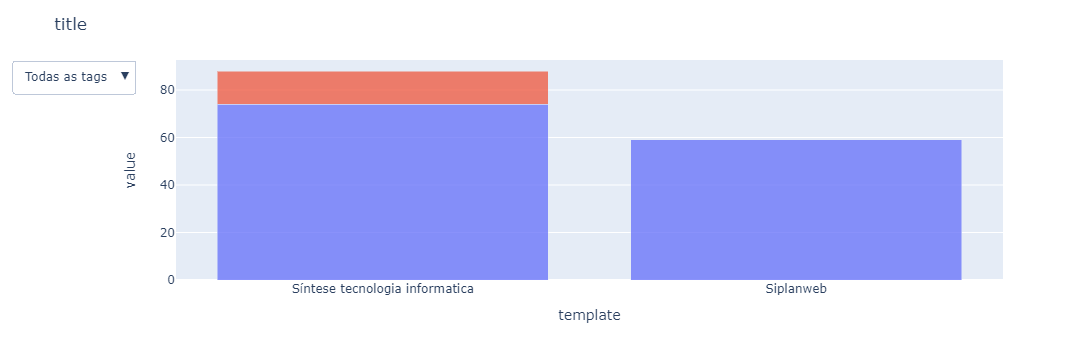

In [228]:
fig =  px.bar(df, x="template", y=["closed", "open"])

fig.update_layout(barmode='stack')

tag_list = pd.unique(df['tag']).tolist() 
buttons = []
    
buttons.append(dict(method = "restyle",
                args = [{'y': [df['closed'], df['open']], 'x': [df['template']]}],
                label = "Todas as tags"))
    
for tag in tag_list:
    aux = df.loc[df['tag'] == tag]
    
    buttons.append(dict(method = "restyle",
                args = [{'y': [aux['closed'], aux['open']], 'x':[aux['template']]},],
                label = tag))
    
fig.update_layout(autosize=True, title='title',
                  updatemenus=[dict(active=0,
                                    buttons=buttons)
                              ]) 

fig.update_traces(opacity=0.75, showlegend=False)

In [241]:
fig1, fig2 = figures.create_figures_dev()

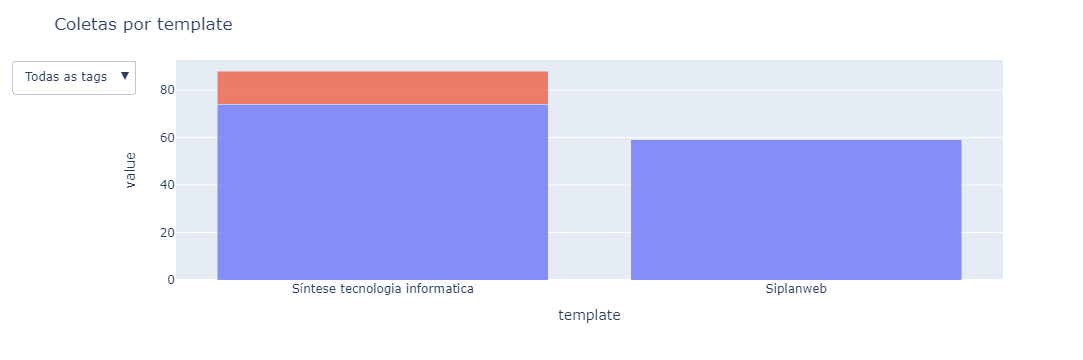

In [243]:
fig2.show()

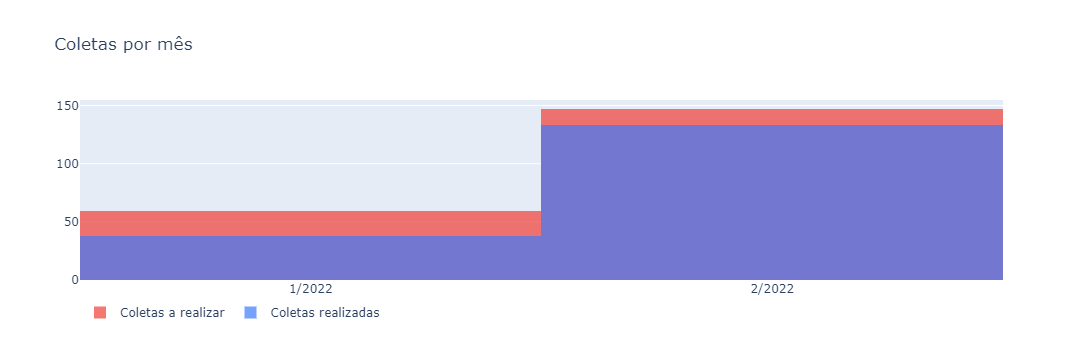

In [242]:
fig1.show()